In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_conv_3_VGG_BN(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=3, filters=64, strides=1, 
                      padding='same', input_shape=input_shape)) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv1D (kernel_size=3, filters=64, strides=1, 
                      padding='same')) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=3, filters=64*(2**int((i+1)/4)), strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Conv1D (kernel_size=3, filters=64*(2**int((i+1)/4)), strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=2, strides=2))

    model.add(Flatten())
    model.add(BatchNormalization())
#     model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 14):
    model = build_1d_cnn_custom_conv_3_VGG_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 64)         256       
_________________________________________________________________
activation (Activation)      (None, 16000, 64)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 16000, 64)         256       
_________________________________________________________________
activation_1 (Activation)    (None, 16000, 64)         0         
_________________________________________________________________
flat

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_24 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_20 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_25 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_21 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 16000, 64)         12352     
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_48 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_42 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_49 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_43 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 16000, 64)         12352     
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_72 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_80 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_72 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_81 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_73 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 16000, 64)         12352     
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_90 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_99 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_90 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_91 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_100 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_91 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_92 (Conv1D)           (None, 16000, 64)         12352     
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_110 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_120 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_110 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_111 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_121 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_111 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_112 (Conv1D)          (None, 16000, 64)         12352     
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_132 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_143 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_132 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_133 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_144 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_133 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_134 (Conv1D)          (None, 16000, 64)         12352     
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_156 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_168 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_156 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_157 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_169 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_157 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_158 (Conv1D)          (None, 16000, 64)         12352     
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.8037 - acc: 0.4039
Epoch 00001: val_loss improved from inf to 2.35966, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_BN_3_conv_checkpoint/001-2.3597.hdf5
36805/36805 [==============================] - 176s 5ms/sample - loss: 2.8041 - acc: 0.4039 - val_loss: 2.3597 - val_acc: 0.3960
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7441 - acc: 0.8249
Epoch 00002: val_loss did not improve from 2.35966
36805/36805 [==============================] - 167s 5ms/sample - loss: 0.7442 - acc: 0.8249 - val_loss: 2.5809 - val_acc: 0.4428
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2740 - acc: 0.9468
Epoch 00003: val_loss did not improve from 2.35966
36805/36805 [==============================] - 167s 5ms/sample - loss: 0.2740 - acc: 0.9468 - val_los

36800/36805 [============================>.] - ETA: 0s - loss: 0.0820 - acc: 0.9867
Epoch 00029: val_loss did not improve from 2.35966
36805/36805 [==============================] - 167s 5ms/sample - loss: 0.0820 - acc: 0.9867 - val_loss: 5.2358 - val_acc: 0.4738
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0750 - acc: 0.9883
Epoch 00030: val_loss did not improve from 2.35966
36805/36805 [==============================] - 167s 5ms/sample - loss: 0.0750 - acc: 0.9883 - val_loss: 5.2165 - val_acc: 0.4845
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0853 - acc: 0.9865
Epoch 00031: val_loss did not improve from 2.35966
36805/36805 [==============================] - 167s 5ms/sample - loss: 0.0853 - acc: 0.9865 - val_loss: 5.5023 - val_acc: 0.4705
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0814 - acc: 0.9872
Epoch 00032: val_loss did not improve from 2.35966
36805/36805 [=====================

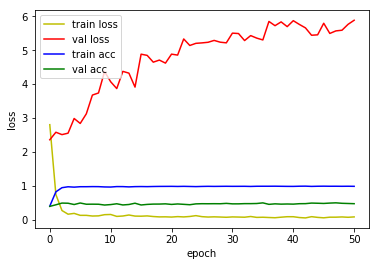

4815/4815 [==============================] - 8s 2ms/sample - loss: 2.3640 - acc: 0.3902
Loss: 2.3640441237951735 Accuracy: 0.39023885

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3123 - acc: 0.4218
Epoch 00001: val_loss improved from inf to 2.58423, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_BN_4_conv_checkpoint/001-2.5842.hdf5
36805/36805 [==============================] - 195s 5ms/sample - loss: 2.3124 - acc: 0.4218 - val_loss: 2.5842 - val_acc: 0.3580
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8621 - acc: 0.7552
Epoch 00002: val_loss improved from 2.58423 to 1.97691, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_BN_4_conv_checkpoint/002-1.9769.hdf5
36805/36805 [==============================] - 182s 5ms/sample - loss: 0.8622 - acc: 0.7551 - val_loss: 1.9769 - val_acc: 0.5127
Epoch 3/500
36800/36805 [============================>

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0472 - acc: 0.9902
Epoch 00029: val_loss did not improve from 1.91319
36805/36805 [==============================] - 181s 5ms/sample - loss: 0.0481 - acc: 0.9901 - val_loss: 3.5750 - val_acc: 0.5444
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0531 - acc: 0.9899
Epoch 00030: val_loss did not improve from 1.91319
36805/36805 [==============================] - 181s 5ms/sample - loss: 0.0531 - acc: 0.9898 - val_loss: 3.6216 - val_acc: 0.5493
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0384 - acc: 0.9930
Epoch 00031: val_loss did not improve from 1.91319
36805/36805 [==============================] - 181s 5ms/sample - loss: 0.0384 - acc: 0.9930 - val_loss: 3.8347 - val_acc: 0.5372
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0417 - acc: 0.9925
Epoch 00032: val_loss did not improve from 1.91319
36805/36805 [========

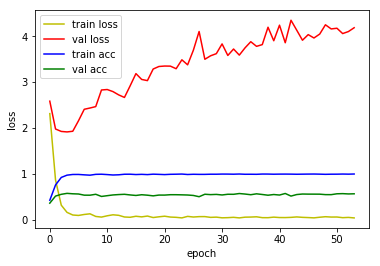

4815/4815 [==============================] - 8s 2ms/sample - loss: 2.0532 - acc: 0.5306
Loss: 2.0531809329243833 Accuracy: 0.53063345

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2051 - acc: 0.4428
Epoch 00001: val_loss improved from inf to 1.86560, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_BN_5_conv_checkpoint/001-1.8656.hdf5
36805/36805 [==============================] - 215s 6ms/sample - loss: 2.2048 - acc: 0.4429 - val_loss: 1.8656 - val_acc: 0.4547
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9057 - acc: 0.7475
Epoch 00002: val_loss did not improve from 1.86560
36805/36805 [==============================] - 197s 5ms/sample - loss: 0.9061 - acc: 0.7475 - val_loss: 2.0336 - val_acc: 0.5215
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3663 - acc: 0.8987
Epoch 00003: val_loss improved from 1.86560 to 1.78576, saving mo

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0597 - acc: 0.9883
Epoch 00029: val_loss did not improve from 1.68659
36805/36805 [==============================] - 197s 5ms/sample - loss: 0.0597 - acc: 0.9883 - val_loss: 2.8511 - val_acc: 0.6427
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0415 - acc: 0.9925
Epoch 00030: val_loss did not improve from 1.68659
36805/36805 [==============================] - 197s 5ms/sample - loss: 0.0418 - acc: 0.9924 - val_loss: 2.8827 - val_acc: 0.6322
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0765 - acc: 0.9837
Epoch 00031: val_loss did not improve from 1.68659
36805/36805 [==============================] - 197s 5ms/sample - loss: 0.0764 - acc: 0.9837 - val_loss: 3.0899 - val_acc: 0.6175
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0465 - acc: 0.9907
Epoch 00032: val_loss did not improve from 1.68659
36805/36805 [========

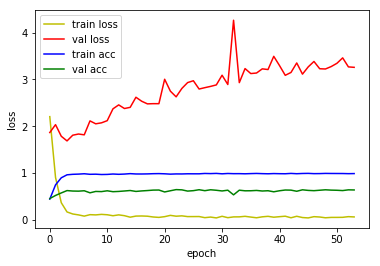

4815/4815 [==============================] - 9s 2ms/sample - loss: 1.8076 - acc: 0.5923
Loss: 1.8075694526838737 Accuracy: 0.5923157

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9833 - acc: 0.4558
Epoch 00001: val_loss improved from inf to 1.73785, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_BN_6_conv_checkpoint/001-1.7379.hdf5
36805/36805 [==============================] - 230s 6ms/sample - loss: 1.9832 - acc: 0.4558 - val_loss: 1.7379 - val_acc: 0.4929
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0963 - acc: 0.6887
Epoch 00002: val_loss improved from 1.73785 to 1.38826, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_BN_6_conv_checkpoint/002-1.3883.hdf5
36805/36805 [==============================] - 205s 6ms/sample - loss: 1.0963 - acc: 0.6887 - val_loss: 1.3883 - val_acc: 0.6452
Epoch 3/500
36800/36805 [============================>.

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0496 - acc: 0.9887
Epoch 00029: val_loss did not improve from 1.23154
36805/36805 [==============================] - 205s 6ms/sample - loss: 0.0498 - acc: 0.9886 - val_loss: 1.9344 - val_acc: 0.6848
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0587 - acc: 0.9850
Epoch 00030: val_loss did not improve from 1.23154
36805/36805 [==============================] - 205s 6ms/sample - loss: 0.0589 - acc: 0.9850 - val_loss: 2.0061 - val_acc: 0.6818
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0573 - acc: 0.9858
Epoch 00031: val_loss did not improve from 1.23154
36805/36805 [==============================] - 205s 6ms/sample - loss: 0.0574 - acc: 0.9858 - val_loss: 2.0570 - val_acc: 0.6825
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0533 - acc: 0.9865
Epoch 00032: val_loss did not improve from 1.23154
36805/36805 [========

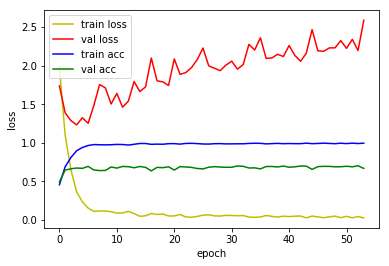

4815/4815 [==============================] - 10s 2ms/sample - loss: 1.3120 - acc: 0.6417
Loss: 1.3119915772078565 Accuracy: 0.64174455

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8750 - acc: 0.4489
Epoch 00001: val_loss improved from inf to 1.76630, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_BN_7_conv_checkpoint/001-1.7663.hdf5
36805/36805 [==============================] - 244s 7ms/sample - loss: 1.8750 - acc: 0.4489 - val_loss: 1.7663 - val_acc: 0.4610
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1118 - acc: 0.6760
Epoch 00002: val_loss improved from 1.76630 to 1.22384, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_BN_7_conv_checkpoint/002-1.2238.hdf5
36805/36805 [==============================] - 210s 6ms/sample - loss: 1.1118 - acc: 0.6760 - val_loss: 1.2238 - val_acc: 0.6769
Epoch 3/500
36800/36805 [============================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0518 - acc: 0.9869
Epoch 00028: val_loss did not improve from 0.87241
36805/36805 [==============================] - 210s 6ms/sample - loss: 0.0520 - acc: 0.9869 - val_loss: 1.2014 - val_acc: 0.7722
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0434 - acc: 0.9893
Epoch 00029: val_loss did not improve from 0.87241
36805/36805 [==============================] - 210s 6ms/sample - loss: 0.0435 - acc: 0.9892 - val_loss: 1.3005 - val_acc: 0.7626
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0430 - acc: 0.9894
Epoch 00030: val_loss did not improve from 0.87241
36805/36805 [==============================] - 210s 6ms/sample - loss: 0.0430 - acc: 0.9894 - val_loss: 1.1192 - val_acc: 0.7862
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0319 - acc: 0.9932
Epoch 00031: val_loss did not improve from 0.87241
36805/36805 [=====================

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0203 - acc: 0.9958
Epoch 00058: val_loss did not improve from 0.87241
36805/36805 [==============================] - 210s 6ms/sample - loss: 0.0203 - acc: 0.9958 - val_loss: 1.4525 - val_acc: 0.7731

1D_CNN_custom_conv_3_VGG_pool_2_BN_7_conv Model


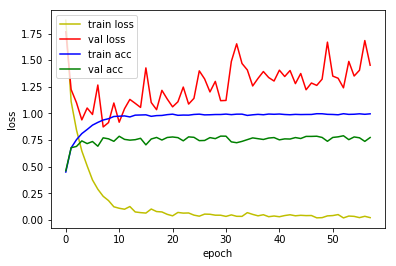

4815/4815 [==============================] - 10s 2ms/sample - loss: 0.9608 - acc: 0.7462
Loss: 0.9608338521895998 Accuracy: 0.74620974

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8906 - acc: 0.4351
Epoch 00001: val_loss improved from inf to 1.62951, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_BN_8_conv_checkpoint/001-1.6295.hdf5
36805/36805 [==============================] - 258s 7ms/sample - loss: 1.8907 - acc: 0.4351 - val_loss: 1.6295 - val_acc: 0.4987
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1102 - acc: 0.6683
Epoch 00002: val_loss improved from 1.62951 to 1.00611, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_BN_8_conv_checkpoint/002-1.0061.hdf5
36805/36805 [==============================] - 213s 6ms/sample - loss: 1.1105 - acc: 0.6683 - val_loss: 1.0061 - val_acc: 0.7056
Epoch 3/500
36800/36805 [============================

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1099 - acc: 0.9667
Epoch 00027: val_loss did not improve from 0.59698
36805/36805 [==============================] - 213s 6ms/sample - loss: 0.1099 - acc: 0.9667 - val_loss: 0.6471 - val_acc: 0.8549
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0538 - acc: 0.9859
Epoch 00028: val_loss did not improve from 0.59698
36805/36805 [==============================] - 213s 6ms/sample - loss: 0.0539 - acc: 0.9858 - val_loss: 0.6978 - val_acc: 0.8474
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0580 - acc: 0.9854
Epoch 00029: val_loss did not improve from 0.59698
36805/36805 [==============================] - 213s 6ms/sample - loss: 0.0579 - acc: 0.9854 - val_loss: 0.7388 - val_acc: 0.8365
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0324 - acc: 0.9932
Epoch 00030: val_loss did not improve from 0.59698
36805/36805 [========

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0226 - acc: 0.9951
Epoch 00057: val_loss did not improve from 0.59698
36805/36805 [==============================] - 213s 6ms/sample - loss: 0.0227 - acc: 0.9950 - val_loss: 0.7438 - val_acc: 0.8509
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0402 - acc: 0.9878
Epoch 00058: val_loss did not improve from 0.59698
36805/36805 [==============================] - 213s 6ms/sample - loss: 0.0402 - acc: 0.9878 - val_loss: 0.7655 - val_acc: 0.8586
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0187 - acc: 0.9958
Epoch 00059: val_loss did not improve from 0.59698
36805/36805 [==============================] - 213s 6ms/sample - loss: 0.0187 - acc: 0.9958 - val_loss: 0.7359 - val_acc: 0.8558
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0202 - acc: 0.9961
Epoch 00060: val_loss did not improve from 0.59698
36805/36805 [========

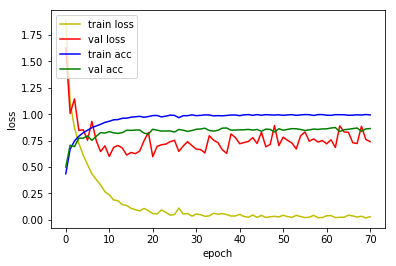

4815/4815 [==============================] - 11s 2ms/sample - loss: 0.6860 - acc: 0.8411
Loss: 0.6860222424302146 Accuracy: 0.8411215

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8610 - acc: 0.4469
Epoch 00001: val_loss improved from inf to 1.76715, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_BN_9_conv_checkpoint/001-1.7672.hdf5
36805/36805 [==============================] - 266s 7ms/sample - loss: 1.8609 - acc: 0.4470 - val_loss: 1.7672 - val_acc: 0.4642
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0821 - acc: 0.6776
Epoch 00002: val_loss improved from 1.76715 to 0.98031, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_BN_9_conv_checkpoint/002-0.9803.hdf5
36805/36805 [==============================] - 207s 6ms/sample - loss: 1.0821 - acc: 0.6775 - val_loss: 0.9803 - val_acc: 0.7156
Epoch 3/500
36800/36805 [============================>

36805/36805 [==============================] - 207s 6ms/sample - loss: 0.0470 - acc: 0.9870 - val_loss: 0.4212 - val_acc: 0.9154
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0438 - acc: 0.9872
Epoch 00027: val_loss did not improve from 0.42122
36805/36805 [==============================] - 207s 6ms/sample - loss: 0.0438 - acc: 0.9872 - val_loss: 0.4272 - val_acc: 0.9043
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0330 - acc: 0.9910
Epoch 00028: val_loss did not improve from 0.42122
36805/36805 [==============================] - 207s 6ms/sample - loss: 0.0330 - acc: 0.9910 - val_loss: 0.5508 - val_acc: 0.8861
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0538 - acc: 0.9846
Epoch 00029: val_loss did not improve from 0.42122
36805/36805 [==============================] - 206s 6ms/sample - loss: 0.0538 - acc: 0.9846 - val_loss: 0.4984 - val_acc: 0.9022
Epoch 30/500
36800/36805 [==============

36800/36805 [============================>.] - ETA: 0s - loss: 0.0242 - acc: 0.9928
Epoch 00056: val_loss did not improve from 0.42122
36805/36805 [==============================] - 207s 6ms/sample - loss: 0.0242 - acc: 0.9928 - val_loss: 0.4754 - val_acc: 0.9136
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0225 - acc: 0.9937
Epoch 00057: val_loss did not improve from 0.42122
36805/36805 [==============================] - 207s 6ms/sample - loss: 0.0226 - acc: 0.9937 - val_loss: 0.5236 - val_acc: 0.9080
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0315 - acc: 0.9910
Epoch 00058: val_loss did not improve from 0.42122
36805/36805 [==============================] - 207s 6ms/sample - loss: 0.0315 - acc: 0.9910 - val_loss: 0.5257 - val_acc: 0.9057
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0179 - acc: 0.9949
Epoch 00059: val_loss did not improve from 0.42122
36805/36805 [=====================

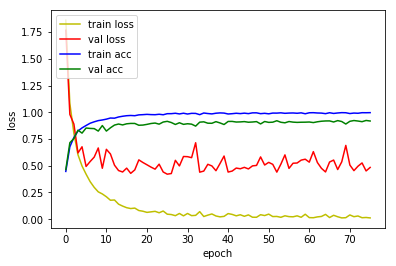

4815/4815 [==============================] - 11s 2ms/sample - loss: 0.4995 - acc: 0.8935
Loss: 0.4994610071677409 Accuracy: 0.89345795

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9132 - acc: 0.4232
Epoch 00001: val_loss improved from inf to 1.84038, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_BN_10_conv_checkpoint/001-1.8404.hdf5
36805/36805 [==============================] - 289s 8ms/sample - loss: 1.9132 - acc: 0.4232 - val_loss: 1.8404 - val_acc: 0.4205
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0051 - acc: 0.7017
Epoch 00002: val_loss improved from 1.84038 to 0.79146, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_BN_10_conv_checkpoint/002-0.7915.hdf5
36805/36805 [==============================] - 209s 6ms/sample - loss: 1.0052 - acc: 0.7017 - val_loss: 0.7915 - val_acc: 0.7626
Epoch 3/500
36800/36805 [==========================

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0510 - acc: 0.9842
Epoch 00027: val_loss improved from 0.24943 to 0.24610, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_BN_10_conv_checkpoint/027-0.2461.hdf5
36805/36805 [==============================] - 210s 6ms/sample - loss: 0.0510 - acc: 0.9842 - val_loss: 0.2461 - val_acc: 0.9338
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0289 - acc: 0.9917
Epoch 00028: val_loss did not improve from 0.24610
36805/36805 [==============================] - 209s 6ms/sample - loss: 0.0289 - acc: 0.9917 - val_loss: 0.2483 - val_acc: 0.9404
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0249 - acc: 0.9924
Epoch 00029: val_loss improved from 0.24610 to 0.24162, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_BN_10_conv_checkpoint/029-0.2416.hdf5
36805/36805 [==============================] - 210s 6ms/sample - loss: 0.0249 - ac

36800/36805 [============================>.] - ETA: 0s - loss: 0.0093 - acc: 0.9976
Epoch 00054: val_loss did not improve from 0.20803
36805/36805 [==============================] - 210s 6ms/sample - loss: 0.0094 - acc: 0.9975 - val_loss: 0.2649 - val_acc: 0.9439
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0220 - acc: 0.9929
Epoch 00055: val_loss did not improve from 0.20803
36805/36805 [==============================] - 210s 6ms/sample - loss: 0.0224 - acc: 0.9929 - val_loss: 0.2860 - val_acc: 0.9406
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0199 - acc: 0.9939
Epoch 00056: val_loss did not improve from 0.20803
36805/36805 [==============================] - 210s 6ms/sample - loss: 0.0199 - acc: 0.9939 - val_loss: 0.2579 - val_acc: 0.9462
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0071 - acc: 0.9982
Epoch 00057: val_loss did not improve from 0.20803
36805/36805 [=====================

Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0188 - acc: 0.9939
Epoch 00084: val_loss did not improve from 0.20803
36805/36805 [==============================] - 209s 6ms/sample - loss: 0.0190 - acc: 0.9939 - val_loss: 0.3108 - val_acc: 0.9390
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0213 - acc: 0.9926
Epoch 00085: val_loss did not improve from 0.20803
36805/36805 [==============================] - 209s 6ms/sample - loss: 0.0213 - acc: 0.9926 - val_loss: 0.2220 - val_acc: 0.9548
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0048 - acc: 0.9988
Epoch 00086: val_loss did not improve from 0.20803
36805/36805 [==============================] - 210s 6ms/sample - loss: 0.0048 - acc: 0.9988 - val_loss: 0.2588 - val_acc: 0.9536
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0030 - acc: 0.9993
Epoch 00087: val_loss did not improve from 0.20803
36805/36805 [========

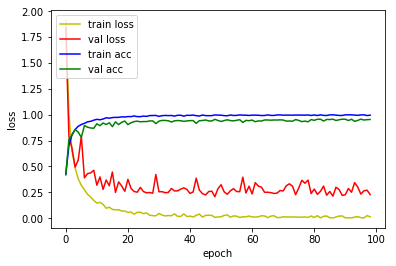

4815/4815 [==============================] - 11s 2ms/sample - loss: 0.2687 - acc: 0.9398
Loss: 0.26865348473349865 Accuracy: 0.93977153

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8724 - acc: 0.4321
Epoch 00001: val_loss improved from inf to 1.50611, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_BN_11_conv_checkpoint/001-1.5061.hdf5
36805/36805 [==============================] - 315s 9ms/sample - loss: 1.8724 - acc: 0.4320 - val_loss: 1.5061 - val_acc: 0.5309
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8266 - acc: 0.7499
Epoch 00002: val_loss improved from 1.50611 to 0.73238, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_BN_11_conv_checkpoint/002-0.7324.hdf5
36805/36805 [==============================] - 212s 6ms/sample - loss: 0.8266 - acc: 0.7499 - val_loss: 0.7324 - val_acc: 0.7857
Epoch 3/500
36800/36805 [=========================

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0194 - acc: 0.9955
Epoch 00027: val_loss did not improve from 0.18728
36805/36805 [==============================] - 212s 6ms/sample - loss: 0.0194 - acc: 0.9955 - val_loss: 0.2261 - val_acc: 0.9446
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0325 - acc: 0.9900
Epoch 00028: val_loss did not improve from 0.18728
36805/36805 [==============================] - 212s 6ms/sample - loss: 0.0326 - acc: 0.9899 - val_loss: 0.2161 - val_acc: 0.9411
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0335 - acc: 0.9902
Epoch 00029: val_loss improved from 0.18728 to 0.18299, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_BN_11_conv_checkpoint/029-0.1830.hdf5
36805/36805 [==============================] - 212s 6ms/sample - loss: 0.0336 - acc: 0.9901 - val_loss: 0.1830 - val_acc: 0.9543
Epoch 30/500
36800/36805 [============================>.] - E

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0071 - acc: 0.9983
Epoch 00056: val_loss improved from 0.15786 to 0.15750, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_BN_11_conv_checkpoint/056-0.1575.hdf5
36805/36805 [==============================] - 213s 6ms/sample - loss: 0.0071 - acc: 0.9983 - val_loss: 0.1575 - val_acc: 0.9623
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0047 - acc: 0.9989
Epoch 00057: val_loss did not improve from 0.15750
36805/36805 [==============================] - 212s 6ms/sample - loss: 0.0047 - acc: 0.9989 - val_loss: 0.1953 - val_acc: 0.9564
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0156 - acc: 0.9953
Epoch 00058: val_loss did not improve from 0.15750
36805/36805 [==============================] - 212s 6ms/sample - loss: 0.0156 - acc: 0.9953 - val_loss: 0.2376 - val_acc: 0.9483
Epoch 59/500
36800/36805 [============================>.] - E

Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0179 - acc: 0.9944
Epoch 00085: val_loss did not improve from 0.15155
36805/36805 [==============================] - 212s 6ms/sample - loss: 0.0178 - acc: 0.9944 - val_loss: 0.1743 - val_acc: 0.9646
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0044 - acc: 0.9989
Epoch 00086: val_loss did not improve from 0.15155
36805/36805 [==============================] - 212s 6ms/sample - loss: 0.0044 - acc: 0.9989 - val_loss: 0.1574 - val_acc: 0.9632
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0032 - acc: 0.9991
Epoch 00087: val_loss did not improve from 0.15155
36805/36805 [==============================] - 212s 6ms/sample - loss: 0.0035 - acc: 0.9991 - val_loss: 0.2224 - val_acc: 0.9546
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0171 - acc: 0.9943
Epoch 00088: val_loss did not improve from 0.15155
36805/36805 [========

Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0038 - acc: 0.9993
Epoch 00115: val_loss did not improve from 0.15155
36805/36805 [==============================] - 212s 6ms/sample - loss: 0.0038 - acc: 0.9993 - val_loss: 0.1735 - val_acc: 0.9634
Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0019 - acc: 0.9995
Epoch 00116: val_loss did not improve from 0.15155
36805/36805 [==============================] - 212s 6ms/sample - loss: 0.0019 - acc: 0.9995 - val_loss: 0.1671 - val_acc: 0.9655
Epoch 117/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0044 - acc: 0.9987
Epoch 00117: val_loss did not improve from 0.15155
36805/36805 [==============================] - 212s 6ms/sample - loss: 0.0044 - acc: 0.9987 - val_loss: 0.4973 - val_acc: 0.9220
Epoch 118/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0165 - acc: 0.9947
Epoch 00118: val_loss did not improve from 0.15155
36805/36805 [====

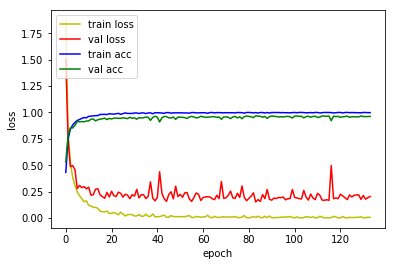

4815/4815 [==============================] - 12s 2ms/sample - loss: 0.1970 - acc: 0.9535
Loss: 0.19696606612016726 Accuracy: 0.9534787

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8138 - acc: 0.4434
Epoch 00001: val_loss improved from inf to 1.47763, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_BN_12_conv_checkpoint/001-1.4776.hdf5
36805/36805 [==============================] - 340s 9ms/sample - loss: 1.8139 - acc: 0.4434 - val_loss: 1.4776 - val_acc: 0.5222
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7229 - acc: 0.7749
Epoch 00002: val_loss improved from 1.47763 to 0.51095, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_BN_12_conv_checkpoint/002-0.5109.hdf5
36805/36805 [==============================] - 214s 6ms/sample - loss: 0.7229 - acc: 0.7749 - val_loss: 0.5109 - val_acc: 0.8425
Epoch 3/500
36800/36805 [==========================

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0409 - acc: 0.9874
Epoch 00025: val_loss improved from 0.13865 to 0.13812, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_BN_12_conv_checkpoint/025-0.1381.hdf5
36805/36805 [==============================] - 214s 6ms/sample - loss: 0.0409 - acc: 0.9874 - val_loss: 0.1381 - val_acc: 0.9588
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0230 - acc: 0.9933
Epoch 00026: val_loss did not improve from 0.13812
36805/36805 [==============================] - 214s 6ms/sample - loss: 0.0230 - acc: 0.9933 - val_loss: 0.1858 - val_acc: 0.9455
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0303 - acc: 0.9911
Epoch 00027: val_loss improved from 0.13812 to 0.13642, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_BN_12_conv_checkpoint/027-0.1364.hdf5
36805/36805 [==============================] - 214s 6ms/sample - loss: 0.0303 - ac

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0203 - acc: 0.9940
Epoch 00054: val_loss did not improve from 0.13215
36805/36805 [==============================] - 214s 6ms/sample - loss: 0.0203 - acc: 0.9940 - val_loss: 0.1502 - val_acc: 0.9644
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0040 - acc: 0.9991
Epoch 00055: val_loss did not improve from 0.13215
36805/36805 [==============================] - 214s 6ms/sample - loss: 0.0040 - acc: 0.9991 - val_loss: 0.1559 - val_acc: 0.9620
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0069 - acc: 0.9982
Epoch 00056: val_loss did not improve from 0.13215
36805/36805 [==============================] - 214s 6ms/sample - loss: 0.0069 - acc: 0.9982 - val_loss: 0.1975 - val_acc: 0.9553
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0129 - acc: 0.9962
Epoch 00057: val_loss did not improve from 0.13215
36805/36805 [========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0072 - acc: 0.9977
Epoch 00083: val_loss did not improve from 0.12927
36805/36805 [==============================] - 214s 6ms/sample - loss: 0.0072 - acc: 0.9977 - val_loss: 0.1601 - val_acc: 0.9627
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0073 - acc: 0.9977
Epoch 00084: val_loss did not improve from 0.12927
36805/36805 [==============================] - 214s 6ms/sample - loss: 0.0075 - acc: 0.9976 - val_loss: 0.1807 - val_acc: 0.9590
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0155 - acc: 0.9954
Epoch 00085: val_loss did not improve from 0.12927
36805/36805 [==============================] - 214s 6ms/sample - loss: 0.0155 - acc: 0.9954 - val_loss: 0.1419 - val_acc: 0.9665
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0125 - acc: 0.9965
Epoch 00086: val_loss did not improve from 0.12927
36805/36805 [=====================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0021 - acc: 0.9995
Epoch 00112: val_loss did not improve from 0.12578
36805/36805 [==============================] - 214s 6ms/sample - loss: 0.0023 - acc: 0.9995 - val_loss: 0.1450 - val_acc: 0.9683
Epoch 113/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0153 - acc: 0.9951
Epoch 00113: val_loss did not improve from 0.12578
36805/36805 [==============================] - 214s 6ms/sample - loss: 0.0153 - acc: 0.9951 - val_loss: 0.1557 - val_acc: 0.9634
Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0020 - acc: 0.9997
Epoch 00114: val_loss did not improve from 0.12578
36805/36805 [==============================] - 214s 6ms/sample - loss: 0.0020 - acc: 0.9997 - val_loss: 0.1372 - val_acc: 0.9688
Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0018 - acc: 0.9996
Epoch 00115: val_loss did not improve from 0.12578
36805/36805 [==================

Epoch 142/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0013 - acc: 0.9997
Epoch 00142: val_loss did not improve from 0.12578
36805/36805 [==============================] - 214s 6ms/sample - loss: 0.0014 - acc: 0.9996 - val_loss: 0.1502 - val_acc: 0.9665
Epoch 143/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0108 - acc: 0.9965
Epoch 00143: val_loss did not improve from 0.12578
36805/36805 [==============================] - 214s 6ms/sample - loss: 0.0108 - acc: 0.9965 - val_loss: 0.1402 - val_acc: 0.9681
Epoch 144/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0047 - acc: 0.9986
Epoch 00144: val_loss did not improve from 0.12578
36805/36805 [==============================] - 214s 6ms/sample - loss: 0.0047 - acc: 0.9986 - val_loss: 0.1458 - val_acc: 0.9686
Epoch 145/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0013 - acc: 0.9997
Epoch 00145: val_loss did not improve from 0.12578
36805/36805 [====

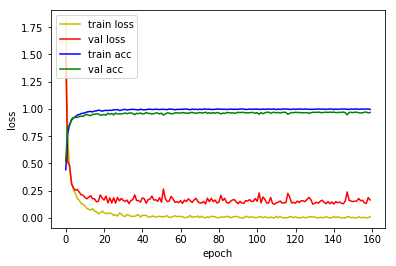

4815/4815 [==============================] - 12s 3ms/sample - loss: 0.1618 - acc: 0.9657
Loss: 0.16177561581853778 Accuracy: 0.9657321

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5891 - acc: 0.5093
Epoch 00001: val_loss improved from inf to 1.23948, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_BN_13_conv_checkpoint/001-1.2395.hdf5
36805/36805 [==============================] - 371s 10ms/sample - loss: 1.5893 - acc: 0.5093 - val_loss: 1.2395 - val_acc: 0.5865
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6382 - acc: 0.7953
Epoch 00002: val_loss improved from 1.23948 to 0.47971, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_pool_2_BN_13_conv_checkpoint/002-0.4797.hdf5
36805/36805 [==============================] - 217s 6ms/sample - loss: 0.6382 - acc: 0.7953 - val_loss: 0.4797 - val_acc: 0.8474
Epoch 3/500
36800/36805 [=========================

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0512 - acc: 0.9836
Epoch 00026: val_loss did not improve from 0.16649
36805/36805 [==============================] - 218s 6ms/sample - loss: 0.0512 - acc: 0.9836 - val_loss: 0.1901 - val_acc: 0.9518
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0210 - acc: 0.9937
Epoch 00027: val_loss did not improve from 0.16649
36805/36805 [==============================] - 218s 6ms/sample - loss: 0.0210 - acc: 0.9937 - val_loss: 0.2104 - val_acc: 0.9490
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0228 - acc: 0.9929
Epoch 00028: val_loss did not improve from 0.16649
36805/36805 [==============================] - 218s 6ms/sample - loss: 0.0230 - acc: 0.9929 - val_loss: 0.1806 - val_acc: 0.9504
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0329 - acc: 0.9894
Epoch 00029: val_loss improved from 0.16649 to 0.15843, saving model to 

36800/36805 [============================>.] - ETA: 0s - loss: 0.0089 - acc: 0.9977
Epoch 00054: val_loss did not improve from 0.14567
36805/36805 [==============================] - 217s 6ms/sample - loss: 0.0089 - acc: 0.9977 - val_loss: 0.1612 - val_acc: 0.9604
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0026 - acc: 0.9994
Epoch 00055: val_loss did not improve from 0.14567
36805/36805 [==============================] - 217s 6ms/sample - loss: 0.0027 - acc: 0.9994 - val_loss: 0.1525 - val_acc: 0.9646
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0142 - acc: 0.9959
Epoch 00056: val_loss did not improve from 0.14567
36805/36805 [==============================] - 217s 6ms/sample - loss: 0.0143 - acc: 0.9958 - val_loss: 0.1777 - val_acc: 0.9620
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0190 - acc: 0.9942
Epoch 00057: val_loss did not improve from 0.14567
36805/36805 [=====================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0049 - acc: 0.9986
Epoch 00083: val_loss did not improve from 0.14422
36805/36805 [==============================] - 218s 6ms/sample - loss: 0.0049 - acc: 0.9986 - val_loss: 0.1808 - val_acc: 0.9571
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0068 - acc: 0.9979
Epoch 00084: val_loss did not improve from 0.14422
36805/36805 [==============================] - 218s 6ms/sample - loss: 0.0068 - acc: 0.9979 - val_loss: 0.1777 - val_acc: 0.9618
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0065 - acc: 0.9982
Epoch 00085: val_loss did not improve from 0.14422
36805/36805 [==============================] - 218s 6ms/sample - loss: 0.0065 - acc: 0.9982 - val_loss: 0.2017 - val_acc: 0.9609
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0101 - acc: 0.9969
Epoch 00086: val_loss did not improve from 0.14422
36805/36805 [=====================

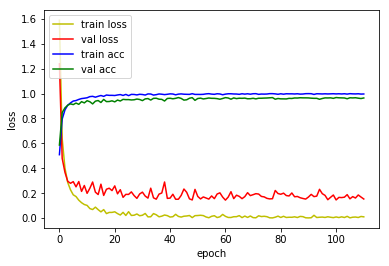

4815/4815 [==============================] - 13s 3ms/sample - loss: 0.1764 - acc: 0.9601
Loss: 0.1764103547913295 Accuracy: 0.9601246



In [10]:
base = '1D_CNN_custom_conv_3_VGG_pool_2_BN'

for i in range(3, 14):
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_conv_3_VGG_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_conv_3_VGG_pool_2_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 14):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_pool_2_BN_3_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_182 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_195 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_182 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_183 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_196 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_183 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_184 (Conv1D)        

4815/4815 [==============================] - 13s 3ms/sample - loss: 1.8076 - acc: 0.5923
Loss: 1.8075694526838737 Accuracy: 0.5923157

1D_CNN_custom_conv_3_VGG_pool_2_BN_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_206 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_222 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_206 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_207 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_223 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_207 (Activatio

4815/4815 [==============================] - 13s 3ms/sample - loss: 0.9608 - acc: 0.7462
Loss: 0.9608338521895998 Accuracy: 0.74620974

1D_CNN_custom_conv_3_VGG_pool_2_BN_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_232 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_250 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_232 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_233 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_251 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_233 (Activati

4815/4815 [==============================] - 14s 3ms/sample - loss: 0.6860 - acc: 0.8411
Loss: 0.6860222424302146 Accuracy: 0.8411215

1D_CNN_custom_conv_3_VGG_pool_2_BN_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_248 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_267 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_248 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_249 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_268 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_249 (Activatio

4815/4815 [==============================] - 14s 3ms/sample - loss: 0.4995 - acc: 0.8935
Loss: 0.4994610071677409 Accuracy: 0.89345795

1D_CNN_custom_conv_3_VGG_pool_2_BN_10_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_266 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_286 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_266 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_267 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_287 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_267 (Activat

4815/4815 [==============================] - 14s 3ms/sample - loss: 0.2687 - acc: 0.9398
Loss: 0.26865348473349865 Accuracy: 0.93977153

1D_CNN_custom_conv_3_VGG_pool_2_BN_11_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_286 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_307 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_286 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_287 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_308 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_287 (Activa

4815/4815 [==============================] - 15s 3ms/sample - loss: 0.1970 - acc: 0.9535
Loss: 0.19696606612016726 Accuracy: 0.9534787

1D_CNN_custom_conv_3_VGG_pool_2_BN_12_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_308 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_330 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_308 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_309 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_331 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_309 (Activat

4815/4815 [==============================] - 15s 3ms/sample - loss: 0.1618 - acc: 0.9657
Loss: 0.16177561581853778 Accuracy: 0.9657321

1D_CNN_custom_conv_3_VGG_pool_2_BN_13_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_332 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_355 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_332 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_333 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_356 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_333 (Activat

4815/4815 [==============================] - 16s 3ms/sample - loss: 0.1764 - acc: 0.9601
Loss: 0.1764103547913295 Accuracy: 0.9601246


In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
# base = '1D_CNN_custom_DO_BN'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(3, 14):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_pool_2_BN_3_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_182 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_195 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_182 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_183 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_196 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_183 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_184 (Conv1D)        

4815/4815 [==============================] - 15s 3ms/sample - loss: 3.7695 - acc: 0.5961
Loss: 3.7694590808198956 Accuracy: 0.596054

1D_CNN_custom_conv_3_VGG_pool_2_BN_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_206 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_222 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_206 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_207 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_223 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_207 (Activation

4815/4815 [==============================] - 16s 3ms/sample - loss: 1.6026 - acc: 0.7483
Loss: 1.6025987649632392 Accuracy: 0.7482866

1D_CNN_custom_conv_3_VGG_pool_2_BN_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_232 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_250 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_232 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_233 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_251 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_233 (Activatio

4815/4815 [==============================] - 17s 4ms/sample - loss: 0.7888 - acc: 0.8546
Loss: 0.7887698325288878 Accuracy: 0.854621

1D_CNN_custom_conv_3_VGG_pool_2_BN_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_248 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_267 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_248 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_249 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_268 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_249 (Activation

4815/4815 [==============================] - 18s 4ms/sample - loss: 0.5586 - acc: 0.8993
Loss: 0.5586357116265955 Accuracy: 0.8992731

1D_CNN_custom_conv_3_VGG_pool_2_BN_10_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_266 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_286 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_266 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_267 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_287 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_267 (Activati

4815/4815 [==============================] - 18s 4ms/sample - loss: 0.2807 - acc: 0.9431
Loss: 0.2807180250763723 Accuracy: 0.9430945

1D_CNN_custom_conv_3_VGG_pool_2_BN_11_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_286 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_307 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_286 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_287 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_308 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_287 (Activati

4815/4815 [==============================] - 18s 4ms/sample - loss: 0.2152 - acc: 0.9566
Loss: 0.2151849320509076 Accuracy: 0.956594

1D_CNN_custom_conv_3_VGG_pool_2_BN_12_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_308 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_330 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_308 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_309 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_331 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_309 (Activatio

4815/4815 [==============================] - 19s 4ms/sample - loss: 0.1956 - acc: 0.9612
Loss: 0.19560887005813213 Accuracy: 0.96116304

1D_CNN_custom_conv_3_VGG_pool_2_BN_13_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_332 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_355 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_332 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_333 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_356 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_333 (Activa

4815/4815 [==============================] - 19s 4ms/sample - loss: 0.1801 - acc: 0.9616
Loss: 0.18005223404200263 Accuracy: 0.9615784
